<a href="https://colab.research.google.com/github/slneha/AIPI590_Fall2025/blob/main/Assignment6/Human%20AI%20Interaction_Explanation%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👩‍⚖️ ⚖️ Human-AI Interaction (nls58)

This notebook reuses the previous assignment code. This top portion with the reused code is collapsed, skip to the assignment below.





## ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

In [ ]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))


              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [ ]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)


Prediction for Malik Johnson (Recidivism): [0]


Alg no.1: SHAP

In [ ]:
!pip install shap

The original model model_compas is a Random Forest Classifier, so TreeExplainer will be used.

In [ ]:
import shap

model_tree_explainer=shap.TreeExplainer(model_compas)
shap_values=model_tree_explainer.shap_values(focus_instance_compas)
shap.initjs()

In [ ]:
shap_values = model_tree_explainer.shap_values(focus_instance_compas)
shap_values

array([[[ 0.03225392, -0.03225392],
        [-0.00383852,  0.00383852],
        [ 0.06741172, -0.06741172],
        [ 0.14140192, -0.14140192],
        [ 0.00766031, -0.00766031],
        [ 0.00764865, -0.00764865],
        [ 0.01308016, -0.01308016],
        [ 0.0924947 , -0.0924947 ]]])

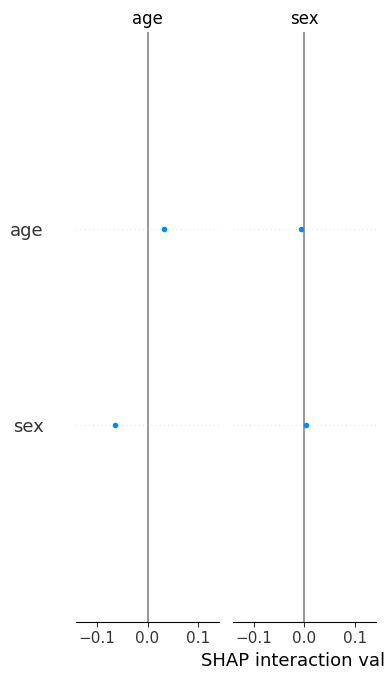

In [ ]:
#local explanation
shap.summary_plot(shap_values, focus_instance_compas, plot_type="bar")

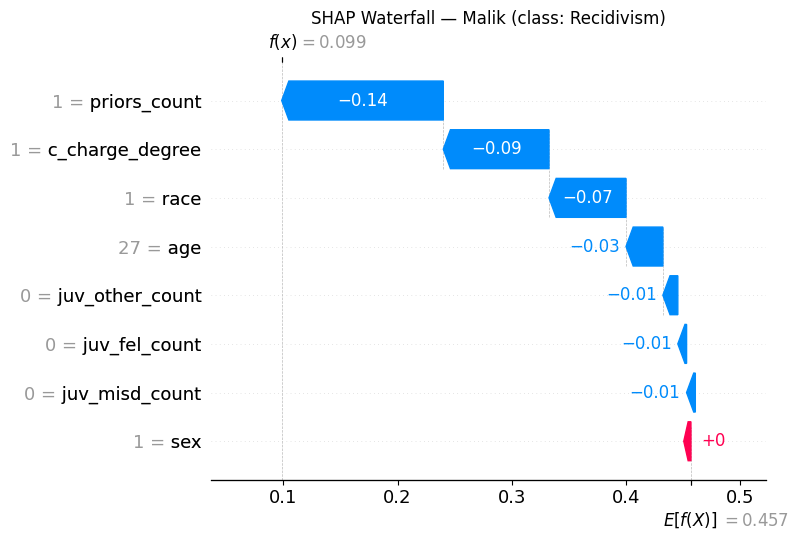

In [ ]:
#IMP - this entire block was generated by ChatGPT to debug why the original SHAP summary plot was only showing age and sex and not anything else

import matplotlib.pyplot as plt

# Build base + contrib from existing objects
row = focus_instance_compas.iloc[0]
sv = shap_values

if isinstance(sv, list):
    contrib = sv[1][0]  # class 1, sample 0
    ev = model_tree_explainer.expected_value
    base = ev[1] if (hasattr(ev, "__len__") and len(np.atleast_1d(ev)) > 1) else ev
else:
    if getattr(sv, "ndim", 2) == 3 and sv.shape[-1] >= 2:
        contrib = sv[0, :, 1]
        ev = model_tree_explainer.expected_value
        base = ev[1] if (hasattr(ev, "__len__") and len(np.atleast_1d(ev)) > 1) else ev
    else:
        contrib = sv[0]
        base = model_tree_explainer.expected_value

# Try modern API, but DO NOT call bare plt.title()/plt.show() afterward
try:
    expl = shap.Explanation(
        values=contrib,
        base_values=base,
        data=row.values,
        feature_names=focus_instance_compas.columns.tolist()
    )
    ax = shap.plots.waterfall(expl, show=False)   # stay on same axes
    if ax is not None:
        ax.set_title("SHAP Waterfall — Malik (class: Recidivism)")
    plt.tight_layout()
    plt.show()

except Exception:
    # Fallback to legacy API which draws on current axes
    shap.waterfall_plot(
        base, contrib,
        features=row.values,
        feature_names=focus_instance_compas.columns.tolist(),
        show=True
    )


**Local Explanation**

The SHAP interaction plot for `age` and `sex` shows values close to zero, indicating that these demographic factors did not meaningfully interact to influence Malik Johnson's recidivism prediction.  

The SHAP waterfall plot shows a full breakdown of the focus instance. Starting from the model's baseline risk of approximately 0.457, the features overall pushed the prediction downward to about 0.099 (which is quite low risk). The strongest downward pull came from `priors_count=1` (-0.14), followed by `c_charge_degree=Felony` (-0.09) and `race` (-0.07). Age 27 contributed a smaller negative effect (-0.03), while the absence of juvenile offenses added further small negative contributions. Sex had almost no effect.  

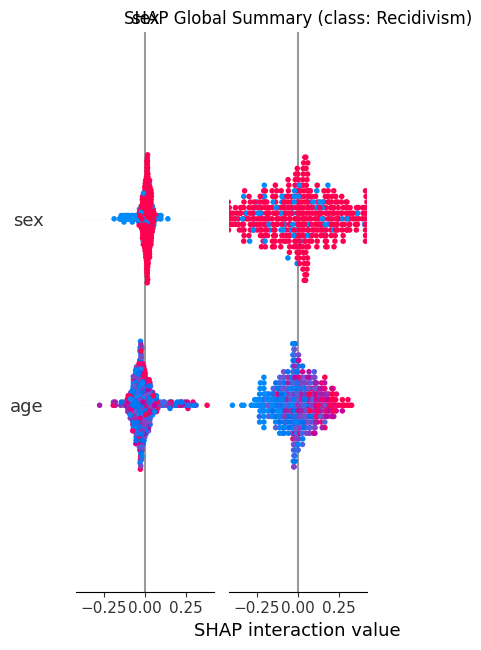

In [ ]:
#global explanation
bg = X_test.sample(min(500, len(X_test)), random_state=0)
sv = model_tree_explainer.shap_values(bg)

# Normalize to positive class (Recidivism = 1), handling both return styles
sv_class1 = sv[1] if isinstance(sv,list) else sv

shap.summary_plot(sv_class1,bg,show=False)
plt.title("SHAP Global Summary (class: Recidivism)")
plt.tight_layout();
plt.show()

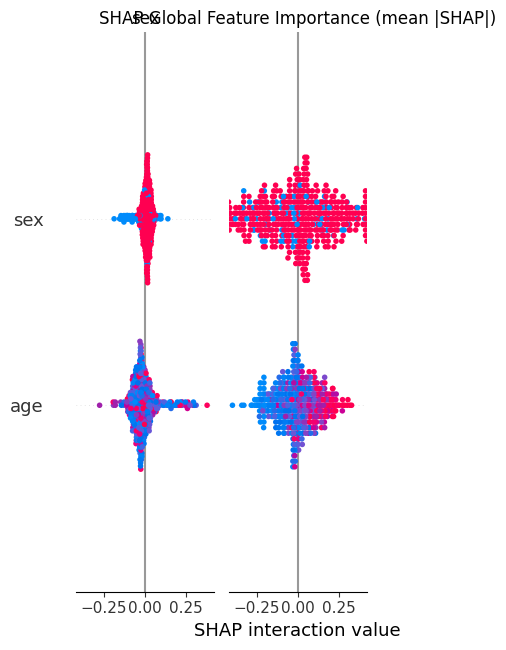

In [ ]:
shap.summary_plot(sv_class1,bg,plot_type="bar",show=False)
plt.title("SHAP Global Feature Importance (mean |SHAP|)")
plt.tight_layout();
plt.show()

The SHAP global summary and feature importance plots show which variables influence recidivism predictions across the dataset the most. The distribution of SHAP values shows that `priors_count` and `c_charge_degree` consistently impact the model's outputs, with higher values tending to increase the likelihood of predicting recidivism. Age also plays a notable role, with younger ages generally associated with higher risk scores. In contrast, demographic variables such as sex and race show relatively small contributions, suggesting that the model relies more on criminal history and charge severity than on demographic attributes when making predictions.


To summarize the findings of both the local and global explantion, it seems that the model heavily relies on priors and charge degree at a population level, and in Malik's case, it underweighted the seriousness of a felony conviction relative to the absence of juvenile history. This combined perspective signifies the consistency of the model's global behavior and potential blind spots in its local application.


**Global Explanation**

For SHAP, both the local and global evaluations are done.

LIME

In [ ]:
!pip install lime

In [ ]:
import lime
import lime.lime_tabular as lime_tabular

In [ ]:
# Initialize LIME explainer
explainer_lime=lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=["No Recidivism", "Recidivism"],
    mode='classification',
    random_state=42
)

In [ ]:
lime_exp = explainer_lime.explain_instance(
    data_row=focus_instance_compas.iloc[0].values,
    predict_fn=model_compas.predict_proba,
    num_features=8  # top 8 features
)
lime_exp.show_in_notebook(show_all=True) # doesn't display properly, refer to plot below for better visualization

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


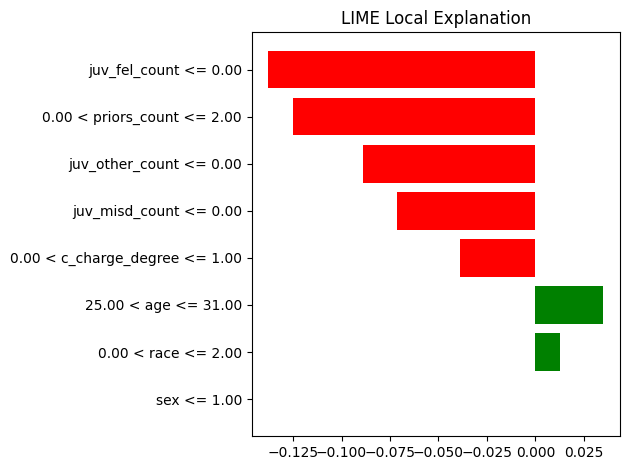

In [ ]:
import matplotlib.pyplot as plt

fig=lime_exp.as_pyplot_figure()
plt.title("LIME Local Explanation")
plt.tight_layout()
plt.show()


The LIME explanation shows that the model relies heavily on the lack of juvenile history (features like juv_fel_count, juv_misd_count, etc with little to no values) to reduce Malik's predicted recidivism risk. Additionally, despite Malik being charged with a felony (c_charge_degree=1) and having one prior adult offense, these factors contributed minimally or even negatively to the risk prediction. Features like age, race, and sex had only a small or lack of positive influence toward higher risk. It is highly likely that the model is unable to comprehend the weight of certain crimes over others. Malik's risk was likely underestimated due to the model's overreliance on juvenile factors and underweighting of serious adult criminal indicators. The model's explanation lacks alignment with real-world patterns of risk and fails to account for the gravity of Malik's adult felony.

In [35]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import euclidean_distances

class SimpleLIME:
    def __init__(self, training_data, feature_names, kernel_width=None, random_state=0):
        """
        training_data: numpy array (n_samples, n_features), numeric-only
        feature_names: list[str]
        kernel_width: if None, uses 0.75 * sqrt(d)
        """
        self.X = np.asarray(training_data)
        self.feature_names = list(feature_names)
        self.d = self.X.shape[1]
        self.rng = np.random.RandomState(random_state)

        # stats for standardization & perturbation
        self.mu = self.X.mean(axis=0)
        self.std = self.X.std(axis=0, ddof=1)
        self.std[self.std == 0.0] = 1.0  # avoid divide-by-zero

        self.kernel_width = kernel_width if kernel_width is not None else (0.75 * np.sqrt(self.d))

    # ---- LIME-style neighborhood sampling (numeric) ----
    def perturb(self, x0, num_samples=5000):
        """
        Sample continuous features around x0 with training std (Gaussian).
        x0: shape (1, d)
        """
        noise = self.rng.normal(loc=0.0, scale=self.std, size=(num_samples, self.d))
        Z = x0 + noise
        return Z

    # ---- standardized Euclidean distance ----
    def _standardized_distance(self, Z, x0):
        Zs = (Z - self.mu) / self.std
        x0s = (x0 - self.mu) / self.std
        return euclidean_distances(Zs, x0s)  # shape (num_samples, 1)

    def kernel(self, distances):
        # LIME kernel: exp(-d^2 / sigma^2)
        return np.exp(-(distances ** 2) / (self.kernel_width ** 2))

    def explain(self, instance, predict_fn, num_samples=5000, target_class=None, K=None, alpha=1.0):
        """
        instance: array-like, shape (1, d)
        predict_fn: model's predict function
            - classification: returns probs shape (n_samples, n_classes)
            - regression: returns shape (n_samples,)
        Returns:
            feature_weights: list[(feature_name, weight)] sorted by |weight| desc
            intercept: float
        """
        x0 = np.asarray(instance).reshape(1, -1)

        # 1) neighborhood
        Z = self.perturb(x0, num_samples=num_samples)

        # 2) predictions
        yhat = predict_fn(Z)
        if yhat.ndim == 2:  # classification
            if target_class is None:
                p0 = predict_fn(x0)
                target_class = int(np.argmax(p0))
            y = yhat[:, target_class]
        else:
            y = yhat  # regression

        # 3) distances in standardized space + kernel weights
        d = self._standardized_distance(Z, x0)           # (N, 1)
        w = self.kernel(d).ravel()                        # (N,)

        # 4) fit locally weighted linear surrogate
        model = Ridge(alpha=alpha, fit_intercept=True)
        model.fit(Z, y, sample_weight=w)

        # 5) package output (optionally select top-K by |coef|)
        coefs = model.coef_.astype(float)
        order = np.argsort(np.abs(coefs))[::-1]
        if K is not None:
            order = order[:K]

        feature_weights = [(self.feature_names[j], coefs[j]) for j in order]
        intercept = float(model.intercept_)

        return feature_weights, intercept


In [36]:
lime_simple = SimpleLIME(X_train.values, X_train.columns.tolist(), kernel_width=None, random_state=0)

feature_weights, intercept = lime_simple.explain(
    focus_instance_compas.values,
    model_compas.predict_proba,
    num_samples=5000,
    K=10,
    alpha=1.0
)

for feat, w in feature_weights:
    print(f"{feat}: {w:+.4f}")
print(f"Intercept: {intercept:.4f}")


juv_fel_count: -0.0749
juv_other_count: -0.0457
juv_misd_count: -0.0270
priors_count: -0.0198
c_charge_degree: +0.0179
sex: -0.0176
age: +0.0160
race: +0.0042
Intercept: 0.0746


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


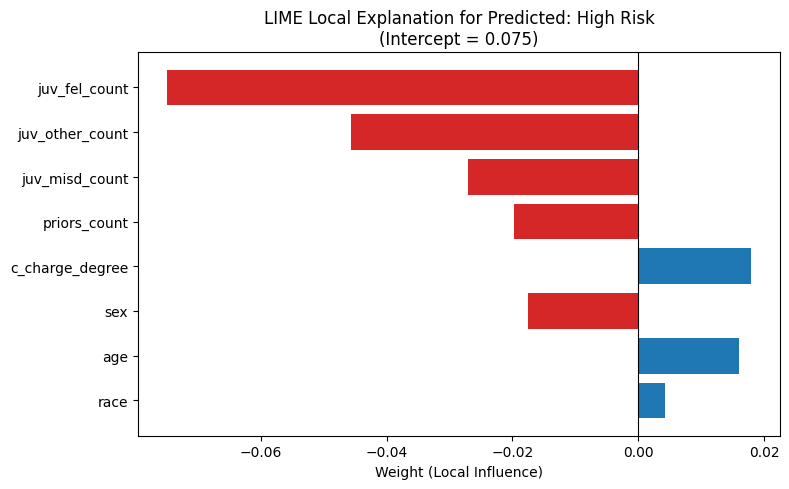

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lime_explanation(feature_weights, intercept=None, instance_label=None, top_k=None):
    # Convert to arrays
    names = np.array([f for f, _ in feature_weights])
    weights = np.array([w for _, w in feature_weights])

    # Optionally trim to top_k
    if top_k is not None:
        names = names[:top_k]
        weights = weights[:top_k]

    # Sort descending by absolute importance for readability
    order = np.argsort(np.abs(weights))
    names, weights = names[order], weights[order]

    colors = ['#1f77b4' if w > 0 else '#d62728' for w in weights]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(weights)), weights, color=colors)
    plt.yticks(range(len(weights)), names, fontsize=10)
    plt.xlabel("Weight (Local Influence)")
    plt.title(
        f"LIME Local Explanation{f' for {instance_label}' if instance_label else ''}\n"
        + (f"(Intercept = {intercept:.3f})" if intercept is not None else "")
    )
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    feature_weights, intercept = lime_simple.explain(
    focus_instance_compas.values,
    model_compas.predict_proba,
    num_samples=5000,
    K=10
)

plot_lime_explanation(feature_weights, intercept, instance_label="Predicted: High Risk", top_k=10)



# Local Interpretable Model-Agnostic Explanations (LIME)

Machine learning models are often described as black boxes because the predictions themselves are shown but not how the model reaches this prediction.  
LIME offers a way to approximate the reasoning of any complex model by training a much simpler, local model around one example of interest.

This tutorial walks through a simplified version of LIME implemented from scratch in Python.  

## 1. Intuition

When a model makes a single prediction, LIME explains *that one case*.  
It does not describe the entire model.  
Instead, it studies how the prediction changes when we make small variations to the input.

Overall Steps (similar to Explanation 1):

1. Take one instance $x_0$ that is to be explained.  
2. Create many slightly different versions of it, aka perturbations.  
3. Ask the model for predictions on all those new samples.  
4. Give higher weight to samples that are close to $x_0$.  
5. Fit a simple linear model on these weighted samples.  
6. Interpret the coefficients of that linear model as local explanations.


## 2. Mathematical form

For each perturbed sample $z_i$:

$$
w_i = \exp\left(-\frac{d(z_i, x_0)^2}{\sigma^2}\right)
$$

where $d(\cdot)$ is the distance between $z_i$ and $x_0$, and $\sigma$ controls how quickly weights decrease with distance.

A weighted linear regression problem is then solved to obtain coefficients that best approximate the original model near $x_0$.

In [65]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
import matplotlib.pyplot as plt

class SimpleLIME:
    """
    SimpleLIME: a compact, step-annotated implementation of LIME.

    Goal
    ----
    Explain a single prediction from any black-box model by learning a simple,
    locally truthful surrogate model around the instance of interest.

    High-level Algorithm (what this class implements)
    -------------------------------------------------
    Step 1  Select the instance x0 to explain.
    Step 2  Build a local neighborhood around x0 (perturbations).
    Step 3  Query the black-box model f for predictions on the neighborhood.
    Step 4  Compute locality weights from distances to x0.
    Step 5  Transform data into an interpretable representation (num passthrough, cat one-hot).
    Step 6  Select a K-sparse interpretable feature set (optional).
    Step 7  Fit a simple, locally weighted linear surrogate g (Ridge) on those features.
    Step 8  Report coefficients (as feature weights), intercept, and store a local fidelity score.

    Return Format (kept identical to the user's original interface)
    ---------------------------------------------------------------
    (feature_weights, intercept)
      - feature_weights: list of (human_readable_feature_name, coefficient), sorted by |coefficient|
      - intercept: float
    """

    def __init__(self,
                 training_data,
                 feature_names,
                 kernel_width=None,
                 random_state=0,
                 categorical_indices=None,
                 categorical_values=None,
                 p_flip=0.1):
        """
        Constructor (inputs the "background data" and configuration).

        Parameters (original-space definitions)
        --------------------------------------
        training_data : np.ndarray (n_samples, d)
            Background data used to estimate numeric scales and categorical value sets.
        feature_names : list[str] (len d)
            Human-readable column names corresponding to training_data columns.
        kernel_width : float or None
            Locality kernel width σ. Defaults to 0.75 * sqrt(d) if None.
        random_state : int
            RNG seed for reproducibility of perturbations.
        categorical_indices : list[int] or None
            Which columns are categorical (by index). If None: assume all numeric.
        categorical_values : dict[int, list] or None
            Allowed categories per categorical column. If None: inferred from training_data.
        p_flip : float in [0,1]
            Probability to flip a categorical feature during perturbation (Step 2).
        """
        # ---- Basic config and bookkeeping -----------------------------------
        self.X = np.asarray(training_data)
        self.feature_names = list(feature_names)
        self.d = self.X.shape[1]
        self.rng = np.random.RandomState(random_state)
        self.kernel_width = kernel_width if kernel_width is not None else (0.75 * np.sqrt(self.d))

        # ---- Identify numeric vs categorical columns in ORIGINAL space -------
        # NOTE: if categorical_indices is None, all columns are treated as numeric
        self.categorical_indices = sorted(list(categorical_indices)) if categorical_indices else []
        self.numeric_indices = [j for j in range(self.d) if j not in self.categorical_indices]

        # ---- Numeric stats for Step 2 (noise scale) and Step 4 (distance) ----
        if self.numeric_indices:
            self.mu_num = self.X[:, self.numeric_indices].mean(axis=0)
            self.std_num = self.X[:, self.numeric_indices].std(axis=0, ddof=1)
            self.std_num[self.std_num == 0.0] = 1.0  # guard against zero variance
        else:
            self.mu_num = np.array([])
            self.std_num = np.array([])

        # ---- Categorical value sets for Step 2 (flips) and Step 5 (one-hot) --
        self.categorical_values = {}
        if self.categorical_indices:
            if categorical_values is not None:
                # If provided, use explicit lists of allowed categories.
                for j in self.categorical_indices:
                    self.categorical_values[j] = list(categorical_values.get(j, []))
            else:
                # Otherwise, infer permissible values from the background data.
                for j in self.categorical_indices:
                    vals = list(dict.fromkeys(self.X[:, j]))  # unique, order-preserving
                    self.categorical_values[j] = vals

        # ---- User-tunable categorical flip probability (Step 2) --------------
        self.p_flip = float(p_flip)

        # ---- Outputs for inspection (Step 8) ---------------------------------
        self.last_fidelity_r2_ = None      # weighted R^2 of the surrogate (local fidelity)
        self.last_target_class_ = None     # if classification, which class we explained

        # ---- Interpretable representation bookkeeping (Step 5) ---------------
        self._transformed_feature_names = None  # names in surrogate space (include one-hot labels)
        self._transformed_map = None            # mapping from transformed cols to original features

    # -------------------------------------------------------------------------
    # Step 5: Build interpretable representation specification
    #         (numeric passthrough, categorical one-hot)
    # -------------------------------------------------------------------------
    def _build_transform_spec(self):
        """
        Create a mapping for the surrogate-space columns:
          - ('num', j)      means "use original numeric column j as-is"
          - ('cat', j, val) means "one-hot column for original categorical column j == val"

        Also create human-readable names to present in explanations, e.g., "gender=Male".
        """
        transformed_names = []
        transformed_spec = []

        # Numeric passthrough columns (retain original names)
        for _, j in enumerate(self.numeric_indices):
            transformed_names.append(self.feature_names[j])
            transformed_spec.append(('num', j))

        # One-hot columns for each categorical value
        for j in self.categorical_indices:
            values = self.categorical_values.get(j, [])
            for val in values:
                transformed_names.append(f"{self.feature_names[j]}={val}")
                transformed_spec.append(('cat', j, val))

        self._transformed_feature_names = transformed_names
        self._transformed_map = transformed_spec

    def _transform_for_surrogate(self, Z):
        """
        Apply the specification (built above) to ORIGINAL-space data Z,
        producing SURROGATE-space matrix Z_t:

          - Numeric columns: copied directly (keeps units interpretable for users).
          - Categorical columns: expanded to one-hot indicators.

        Returns
        -------
        Z_t : np.ndarray, shape (n_samples, n_transformed)
        """
        if self._transformed_map is None:
            self._build_transform_spec()

        cols = []
        for desc in self._transformed_map:
            if desc[0] == 'num':
                _, j = desc
                cols.append(Z[:, j].reshape(-1, 1))
            else:
                _, j, val = desc
                one_hot = (Z[:, j] == val).astype(float).reshape(-1, 1)
                cols.append(one_hot)
        Z_t = np.hstack(cols) if cols else np.zeros((Z.shape[0], 0))
        return Z_t

    # -------------------------------------------------------------------------
    # Step 2: Neighborhood generation (perturb around x0)
    # -------------------------------------------------------------------------
    def perturb(self, x0, num_samples=5000):
        """
        Construct a local neighborhood around x0 in ORIGINAL space.

        Numeric features:
            - Add Gaussian noise with per-feature std estimated from background data.
              (This preserves realistic numeric scales in the neighborhood.)

        Categorical features:
            - With probability p_flip, replace the category with a value sampled from
              the empirical distribution of that column (ensures plausible categories).
        """
        x0 = np.asarray(x0).reshape(1, -1)
        Z = np.repeat(x0, repeats=num_samples, axis=0)

        # Numeric perturbations: Gaussian noise per numeric column
        if self.numeric_indices:
            noise = self.rng.normal(loc=0.0, scale=self.std_num, size=(num_samples, len(self.numeric_indices)))
            Z[:, self.numeric_indices] = Z[:, self.numeric_indices] + noise

        # Categorical perturbations: probabilistic flips to valid categories
        for j in self.categorical_indices:
            if self.p_flip <= 0.0:
                continue
            flip_mask = self.rng.rand(num_samples) < self.p_flip
            if not np.any(flip_mask):
                continue

            vals = self.categorical_values.get(j, [])
            if not vals:
                continue

            # Empirical probabilities from background data (more realistic than uniform)
            counts = Counter(self.X[:, j])
            cats = [v for v in vals]
            probs = np.array([counts.get(v, 0) + 1e-12 for v in vals], dtype=float)
            probs = probs / probs.sum()

            sampled = self.rng.choice(cats, size=flip_mask.sum(), p=probs)
            Z[flip_mask, j] = sampled

        return Z

    # -------------------------------------------------------------------------
    # Step 4: Proximity via distance and kernel weighting
    # -------------------------------------------------------------------------
    def _standardized_distance(self, Z, x0):
        """
        Compute a mixed-type distance d(z, x0):

          - Numeric part: standardized Euclidean distance using background mean/std.
          - Categorical part: Hamming count (number of mismatched categorical features).

        Combine by: d_all = sqrt( d_numeric^2 + mismatches_categorical )
        """
        x0 = np.asarray(x0).reshape(1, -1)

        # Numeric standardized Euclidean
        if self.numeric_indices:
            Z_num = (Z[:, self.numeric_indices] - self.mu_num) / self.std_num
            x0_num = (x0[:, self.numeric_indices] - self.mu_num) / self.std_num
            d_num = euclidean_distances(Z_num, x0_num)  # shape (N, 1)
        else:
            d_num = np.zeros((Z.shape[0], 1))

        # Categorical Hamming mismatches
        if self.categorical_indices:
            mismatches = np.zeros((Z.shape[0],), dtype=float)
            for j in self.categorical_indices:
                mismatches += (Z[:, j] != x0[0, j]).astype(float)
            d_all = np.sqrt(d_num.ravel() ** 2 + mismatches)
        else:
            d_all = d_num.ravel()

        return d_all.reshape(-1, 1)  # shape (N, 1)

    def kernel(self, distances):
        """
        Exponential locality kernel (higher weight for closer points):
            w_i = exp( - d_i^2 / sigma^2 ),  where sigma = kernel_width
        """
        return np.exp(-(distances ** 2) / (self.kernel_width ** 2))

    # -------------------------------------------------------------------------
    # Helpers for Step 7 (feature selection) and Step 8 (fidelity)
    # -------------------------------------------------------------------------
    @staticmethod
    def _weighted_corr(x, y, w):
        """
        Absolute weighted correlation between x and y under weights w.
        Used to rank transformed features before fitting (sparse top-K option).
        """
        w = np.asarray(w).ravel()
        x = np.asarray(x).ravel()
        y = np.asarray(y).ravel()

        W = w.sum()
        mx = (w * x).sum() / W
        my = (w * y).sum() / W
        xc = x - mx
        yc = y - my

        cov = (w * xc * yc).sum() / W
        vx = (w * xc**2).sum() / W
        vy = (w * yc**2).sum() / W
        if vx <= 0 or vy <= 0:
            return 0.0
        return abs(cov / np.sqrt(vx * vy))

    @staticmethod
    def _weighted_r2(y_true, y_pred, w):
        """
        Weighted R^2 (local fidelity):
        how well the simple surrogate matches the black-box predictions in the local neighborhood.
        """
        w = np.asarray(w).ravel()
        W = w.sum()
        y_bar = (w * y_true).sum() / W
        sse = (w * (y_true - y_pred)**2).sum()
        sst = (w * (y_true - y_bar)**2).sum()
        if sst <= 0:
            return 0.0
        return 1.0 - sse / sst

    # -------------------------------------------------------------------------
    # Step 7 (sparsity): Select top-K transformed features BEFORE fitting
    # -------------------------------------------------------------------------
    def _select_topK_transformed(self, Z_t, y, w, K):
        """
        Rank transformed features by absolute weighted correlation with y (under weights w),
        then select the top K indices. This enforces a sparse, human-sized explanation.
        """
        scores = np.array([self._weighted_corr(Z_t[:, j], y, w) for j in range(Z_t.shape[1])])
        order = np.argsort(scores)[::-1]
        return order[:K], scores

    # -------------------------------------------------------------------------
    # Steps 1–8: Main explanation routine (keeps original return format)
    # -------------------------------------------------------------------------
    def explain(self,
                instance,
                predict_fn,
                num_samples=5000,
                target_class=None,
                K=None,
                alpha=1.0):
        """
        Explain a single instance `instance` with respect to a black-box `predict_fn`.

        Returns
        -------
        feature_weights : list[(feature_name, weight)]  -- sorted by |weight| descending
        intercept : float
        """
        # Step 1: Select instance x0 (reshape defensively to 2D)
        x0 = np.asarray(instance).reshape(1, -1)

        # Step 2: Create neighborhood Z around x0
        Z = self.perturb(x0, num_samples=num_samples)

        # Step 3: Query the black-box model on Z
        yhat = predict_fn(Z)
        if yhat.ndim == 2:  # classification (probabilities per class)
            if target_class is None:
                p0 = predict_fn(x0)
                target_class = int(np.argmax(p0))
            y = yhat[:, target_class]
        else:
            y = yhat  # regression target
        self.last_target_class_ = target_class

        # Step 4: Compute locality weights w from distances to x0
        d = self._standardized_distance(Z, x0)     # shape (N, 1)
        w = self.kernel(d).ravel()                 # shape (N,)

        # Step 5: Build interpretable representation (numeric passthrough + cat one-hot)
        Z_t = self._transform_for_surrogate(Z)
        transformed_names = self._transformed_feature_names

        # Step 6 — Select a K-sparse interpretable feature set BEFORE fitting
        selected_t = None
        Z_fit = Z_t
        transformed_idx_map = np.arange(Z_t.shape[1])

        if Z_t.shape[1] > 0 and K is not None and 0 < K < Z_t.shape[1]:
            # Rank transformed features by absolute weighted correlation with y under weights w
            selected_t, _ = self._select_topK_transformed(Z_t, y, w, K)
            # Keep only those K columns for the local surrogate
            Z_fit = Z_t[:, selected_t]
            transformed_idx_map = selected_t


        # Step 7 — Fit the locally weighted linear surrogate (Ridge) on the selected features
        model = Ridge(alpha=alpha, fit_intercept=True)

        if Z_fit.shape[1] == 0:
            # Edge case: if no features selected, fit intercept-only so the code never breaks
            model.fit(np.zeros((Z_fit.shape[0], 1)), y, sample_weight=w)
        else:
            model.fit(Z_fit, y, sample_weight=w)


        # Step 8: Compute and store local fidelity (weighted R^2)
        y_pred = model.predict(Z_fit if Z_fit.shape[1] > 0 else np.zeros((Z_fit.shape[0], 1)))
        self.last_fidelity_r2_ = self._weighted_r2(y_true=y, y_pred=y_pred, w=w)

        # Prepare outputs in the original format
        coefs = model.coef_.astype(float) if Z_fit.shape[1] > 0 else np.array([])
        order = np.argsort(np.abs(coefs))[::-1] if coefs.size else []

        feature_weights = []
        for idx in order:
            tcol = int(transformed_idx_map[idx])
            human_name = transformed_names[tcol]  # e.g., "age" or "gender=Male"
            weight = float(coefs[idx])
            feature_weights.append((human_name, weight))

        intercept = float(model.intercept_)
        return feature_weights, intercept

    # -------------------------------------------------------------------------
    # Visualization helper (optional): quick bar chart for feature weights
    # -------------------------------------------------------------------------
    @staticmethod
    def plot_feature_weights(feature_weights, top_n=10, figsize=(7, 5), title="LIME Explanation (Top Features)"):
        """
        Plot the top-N features (by |weight|) from a (feature_name, weight) list.
        """
        fw = sorted(feature_weights, key=lambda t: abs(t[1]), reverse=True)[:top_n]
        labels = [t[0] for t in fw]
        weights = [t[1] for t in fw]

        y_pos = np.arange(len(labels))
        plt.figure(figsize=figsize)
        plt.barh(y_pos, weights)
        plt.yticks(y_pos, labels)
        plt.axvline(0, linestyle="--", linewidth=1)
        plt.xlabel("Local weight (surrogate coef)")
        plt.title(title)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


In [63]:
lime_simple = SimpleLIME(X_train.values, X_train.columns.tolist(), kernel_width=None, random_state=0)

feature_weights, intercept = lime_simple.explain(
    focus_instance_compas.values,
    model_compas.predict_proba,
    num_samples=5000,
    K=10,
    alpha=1.0
)

for feat, w in feature_weights:
    print(f"{feat}: {w:+.4f}")
print(f"Intercept: {intercept:.4f}")


sex: -0.0562
juv_fel_count: -0.0524
c_charge_degree: +0.0521
juv_other_count: -0.0352
priors_count: -0.0240
age: +0.0177
juv_misd_count: -0.0129
race: +0.0071
Intercept: 0.0609


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


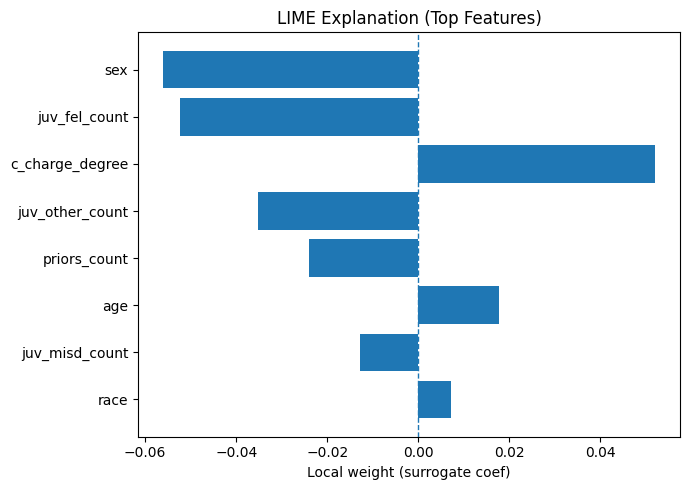

In [67]:
lime_simple.plot_feature_weights(feature_weights, top_n=10)

### Results: Interpreting the Local Explanation

The bar chart and feature weight table represent the local surrogate model that approximates the black-box model's behavior around a single instance.

- Positive weights indicate that these features increase the model's predicted probability for the selected class.  
- Negative weights indicate that these features decrease the predicted probability.  
- Larger magnitudes correspond to stronger influence on the model's local decision.  
- The intercept represents the baseline local prediction when all features are at their mean values.

This interpretation helps us understand why the model made a specific prediction for one data point, without requiring direct access to the internal model parameters.

In this example, the local explanation shows that the feature “c_charge_degree” has the strongest positive influence on the model's prediction for the selected individual. This means that higher values or specific categories of “c_charge_degree” are associated with an increased predicted probability of the target outcome. Conversely, features such as "sex" and "juv_fel_count" have negative weights, indicating that they contribute to lowering the predicted probability for this instance. Other features such as “priors_count” and “age” have smaller but still measurable effects, reflecting secondary influences on the model's local decision.

  

Citation:

The original LIME algorithm implementation and code logic done by by me. ChatGPT was used to add comments according to the algorithm I typed out in Explanation 1 and improve the structure of the code, improve the clarity of comments, etc. The final helper function for visualizing feature weights was also done by ChatGPT. However, all Markdown explanations, documentation text, interpretation sections, etc were done by me.